# Week 1: Getting used to Jupyter Notebooks
### MAQ - 32806, Chiel van Heerwaarden & Imme Benedict, 2016
This is the first tutorial. In this tutorial, you will get used to the Jupyter Notebooks, and their work flow. In Jupyter notebooks you can write either text in Markdown format (including mathematics using LaTeX) or code in Python format. In this course, you will on assignments that you can work out in your own notebook.
___

### SOME ESSENTIAL TIPS BEFORE STARTING!
* Make a copy of the notebook via the `File` menu. By doing so, you always have the original file to revert to.
* Save your work often.
* In case of weird behavior, try to restart via the `Kernel` menu.
* Play around, the best way to find out how things work is to try them out!
* Use the internet for help on `numpy`, `matplotlib`, `Basemap` or `LaTeX` if you want to try something out.
* With `Shift+Enter` you can move down while executing cells.
___

### Setting up a Python Basemap and read out 3D fields
We start the tutorial by loading the required Python packages and setting the figure properties.

In [4]:
import numpy as np              # Numpy is the package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of our meteorological data.
import matplotlib.pyplot as pl  # Matplotlib is a scientific plotting package.

from mpl_toolkits.basemap import Basemap # Import the map plotting interface.

# The statement below enforces the plots to be put inline.
%pylab inline
pl.rcParams.update({'font.size': 12})          # Set the font size of the plots to 12pt.
pl.rcParams.update({'figure.figsize': [13,6]}) # Set the standard figure size.

Populating the interactive namespace from numpy and matplotlib


___
With the code below, you up the world map with the desired coordinates.

In [5]:
lon_start = -150.
lon_end   =   50.
lat_start =   20.
lat_end   =   70.
m = Basemap(llcrnrlon=lon_start,
            llcrnrlat=lat_start,
            urcrnrlon=lon_end,
            urcrnrlat=lat_end,
            projection='mill', resolution='l')

___
Now, you load the data and read out the desired variables from a NetCDF file from the ECMWF ERA-Interim data archive. You are loading a file with data from the first two weeks of October 2015.

In [8]:
nc_file = nc.Dataset("data/test.nc", "r")
lat = nc_file.variables["latitude"][:]
lon = nc_file.variables["longitude"][:]
p = nc_file.variables["level"][:]*100  # Conversion of pressure to Pa.

t = 0 # We only load the first time index from the data.
time = nc_file.variables["time"][0]

# With the code below, we roll the map, to get the 0 meridian,
# rather than the Pacific in the middle.
nroll = lon.size//2
lon = np.roll(lon, nroll)
lon = np.where(lon>=180., lon-360., lon)

# We load 3D fields of the two horizontal wind components, the geopotential and the temperature.
u = np.roll(nc_file.variables["u"][t,:,:,:], nroll, -1)
v = np.roll(nc_file.variables["v"][t,:,:,:], nroll, -1)
z = np.roll(nc_file.variables["z"][t,:,:,:], nroll, -1)
T = np.roll(nc_file.variables["t"][t,:,:,:], nroll, -1)

nc_file.close() # The file access is closed as no further data is needed now.

# We create two-dimensional grids for lons and lats in degrees and radians. These arrays
# are used for plotting and computation.
lons, lats = m(*np.meshgrid(lon, lat))
lonrad, latrad = np.meshgrid(np.pi/180.*lon, np.pi/180.*lat)

This is it. With the actions below, you have done everything to be able to work with ECMWF ERA-Interim weather data.
___

### Working with numpy
Before plotting the data, we have a quick look at the shape of the loaded data. Our 3D fields have three dimensions: `height`, `lat` and `lon` from which we can select the desired fields. Pressure is the height coordinate of our data. Below we show some simple examples.

In [28]:
print(z.shape)     # We have 37 height levels, 241 latitudes and 480 longitudes.
print(p[0])        # Our lowest pressure level is 1000 hPa.
print(p[6])        # At level 6 we find 850 hPa.
z_850 = z[6,:,:]   # We create a new variable that contains only the geopotential height at 850 hPa.
print(z_850.shape) # The new data has only two dimensions, lat and lon.

# We can also write formatted output to the screen.
print("The standard deviation is {0}".format(z_850.std())) # We can format the output.
print("The mean, max and min are {0}, {1}, {2}".format(z_850.mean(), z_850.min(), z_850.max()))

(37, 241, 480)
100000
85000
(241, 480)
The standard deviation is 1316.9922129934616
The mean, max and min are 13697.451031229135, 9624.099091643991, 15978.193350236455


___
### Plotting data
We are now going to plot the temperature and geopotential at 500 hPa. Note that our units are SI.

/usr/local/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


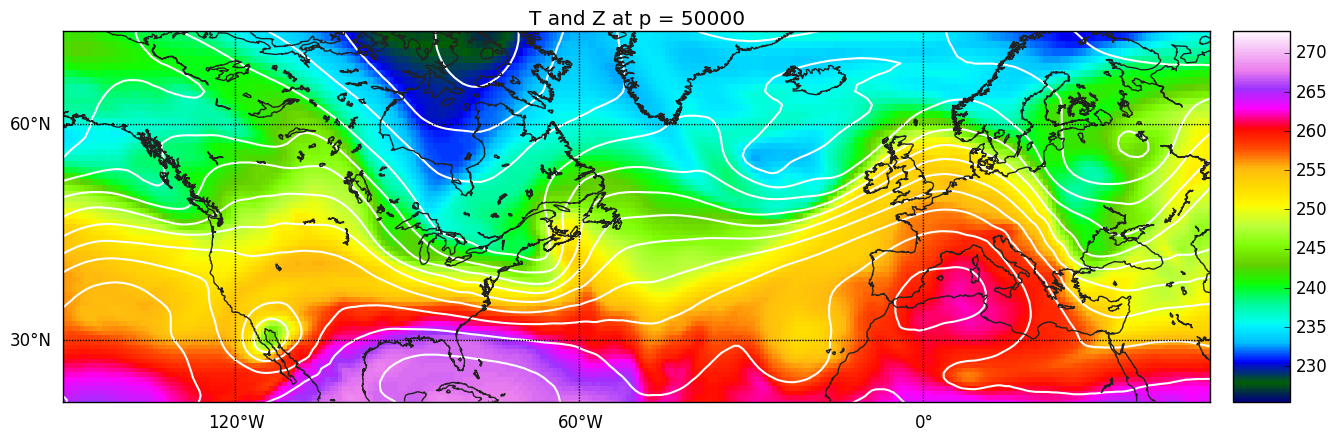

In [32]:
p_plot = 50000.            # Choose the height in pressure level at which you want to plot.
n = abs(p-p_plot).argmin() # This is a trick to find the index closest to the desired value.

m.pcolormesh(lons, lats, T[n,:,:], cmap=pl.cm.gist_ncar)        # We plot a colormesh using the gist_ncar colormap.
m.colorbar()                                                    # We add a colorbar to show the values of temperature.
m.contour(lons, lats, z[n,:,:], 15, colors='w', linewidths=1.5) # We plot the geopotential in contours.
m.drawcoastlines(color='#222222') # We add coastlines.
# Draw parallels.
parallels = np.arange(0.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0])
# Draw meridians.
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('T and Z at p = {0}'.format(p[n])); # We add a title to the plot. 
pl.tight_layout() # With this function we make the figure fit as good as possible.

___
In Python, the underlying language of the notebooks, it is very easy to do manipulations on the data. Below, we calculate for instance the total wind speed and plot it. Again, we make use of the previously defined index of the 500 hPa level `n`. We calculate the total wind speed $U$ as
$$ U = \sqrt{u^2 + v^2}$$

In [ ]:
U = (u**2 + v**2)**.5

m.pcolormesh(lons, lats, U[n,:,:], cmap=pl.cm.gist_ncar)
m.colorbar()
m.contour(lons, lats, z[n,:,:], 15, colors='w', linewidths=1.5)
m.drawcoastlines(color='#222222')
# draw parallels.
parallels = np.arange(0.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('U at p = {0}'.format(p[n]));
pl.tight_layout()

___


In [ ]:
r_earth = 6.37e6

dzdx = np.zeros(z.shape)
dzdy = np.zeros(z.shape)

cos_lat = np.cos(latrad)
for k in range(p.size):
    dzdx[k,:,:] = 1./(r_earth*cos_lat) * np.gradient(z[k,:,:], axis=1) / np.gradient(lonrad, axis=1)

for k in range(p.size):
    dzdy[k,:,:] = (1./r_earth) * np.gradient(z[k,:,:], axis=0) / np.gradient(latrad, axis=0)

omega = 7.2921e-5
f = 2.*omega*np.sin(latrad)
ug = -1./f*dzdy
vg =  1./f*dzdx
Ug = (ug**2 + vg**2)**.5